# Batch Reactor Example
## Ignition delay computation

In this example we will illustrate how to setup and use a constant volume batch reactor. This reactor will then be used to compute the ignition delay of a gas at any temperature and pressure

The reactor (system) is simply an insulated box.

In [1]:
import time

%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import cantera as ct
print(f"Runnning Cantera version: {ct.__version__}")

Runnning Cantera version: 2.5.1


### Import modules and set plotting defaults

In [2]:
plt.rcParams["axes.labelsize"] = 18
plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["ytick.labelsize"] = 12
plt.rcParams["figure.autolayout"] = True

plt.style.use("ggplot")
plt.style.use("seaborn-pastel")

### Define the gas
In this example we will choose n-heptane as the gas. For a representative kinetic model, we use the 160 species [mechanism](https://combustion.llnl.gov/archived-mechanisms/alkanes/heptane-reduced-mechanism) by [Seier et al. 2000, Proc. Comb. Inst](http://dx.doi.org/10.1016/S0082-0784&#40;00&#41;80610-4). 

In [3]:
gas = ct.Solution("data/seiser.yaml")

For species c7h15o-1, discontinuity in h/RT detected at Tmid = 1391.0
	Value computed using low-temperature polynomial:  21.83428060093267
	Value computed using high-temperature polynomial: 21.76699500201913



### Define reactor conditions : temperature, pressure, fuel, stoichiometry

In [4]:
# Define the reactor temperature and pressure
reactor_temperature = 1000  # Kelvin
reactor_pressure = 101325  # Pascals

gas.TP = reactor_temperature, reactor_pressure

# Define the fuel, oxidizer and set the stoichiometry
gas.set_equivalence_ratio(phi=1.0, fuel="nc7h16", oxidizer={"o2": 1.0, "n2": 3.76})

# Create a batch reactor object and add it to a reactor network
# In this example, the batch reactor will be the only reactor
# in the network
r = ct.IdealGasReactor(contents=gas, name="Batch Reactor")
reactor_network = ct.ReactorNet([r])

# use the above list to create a DataFrame
time_history = ct.SolutionArray(gas, extra="t")

### Define useful functions

In [5]:
def ignition_delay(states, species):
    """
    This function computes the ignition delay from the occurence of the
    peak in species' concentration.
    """
    i_ign = states(species).Y.argmax()
    return states.t[i_ign]

In [6]:
reference_species = "oh"

# Tic
t0 = time.time()

# This is a starting estimate. If you do not get an ignition within this time, increase it
estimated_ignition_delay_time = 0.1
t = 0

while t < estimated_ignition_delay_time:
    t = reactor_network.step()
    time_history.append(r.thermo.state, t=t)

# We will use the 'oh' species to compute the ignition delay
tau = ignition_delay(time_history, reference_species)

# Toc
t1 = time.time()

print(f"Computed Ignition Delay: {tau:.3e} seconds. Took {t1-t0:.2f}s to compute")

# If you want to save all the data - molefractions, temperature, pressure, etc
# uncomment the next line
# time_history.to_csv("time_history.csv")

Computed Ignition Delay: 3.248e-02 seconds. Took 0.78s to compute


## Plot the result

### Figure illustrating the definition of ignition delay

<IPython.core.display.Javascript object>


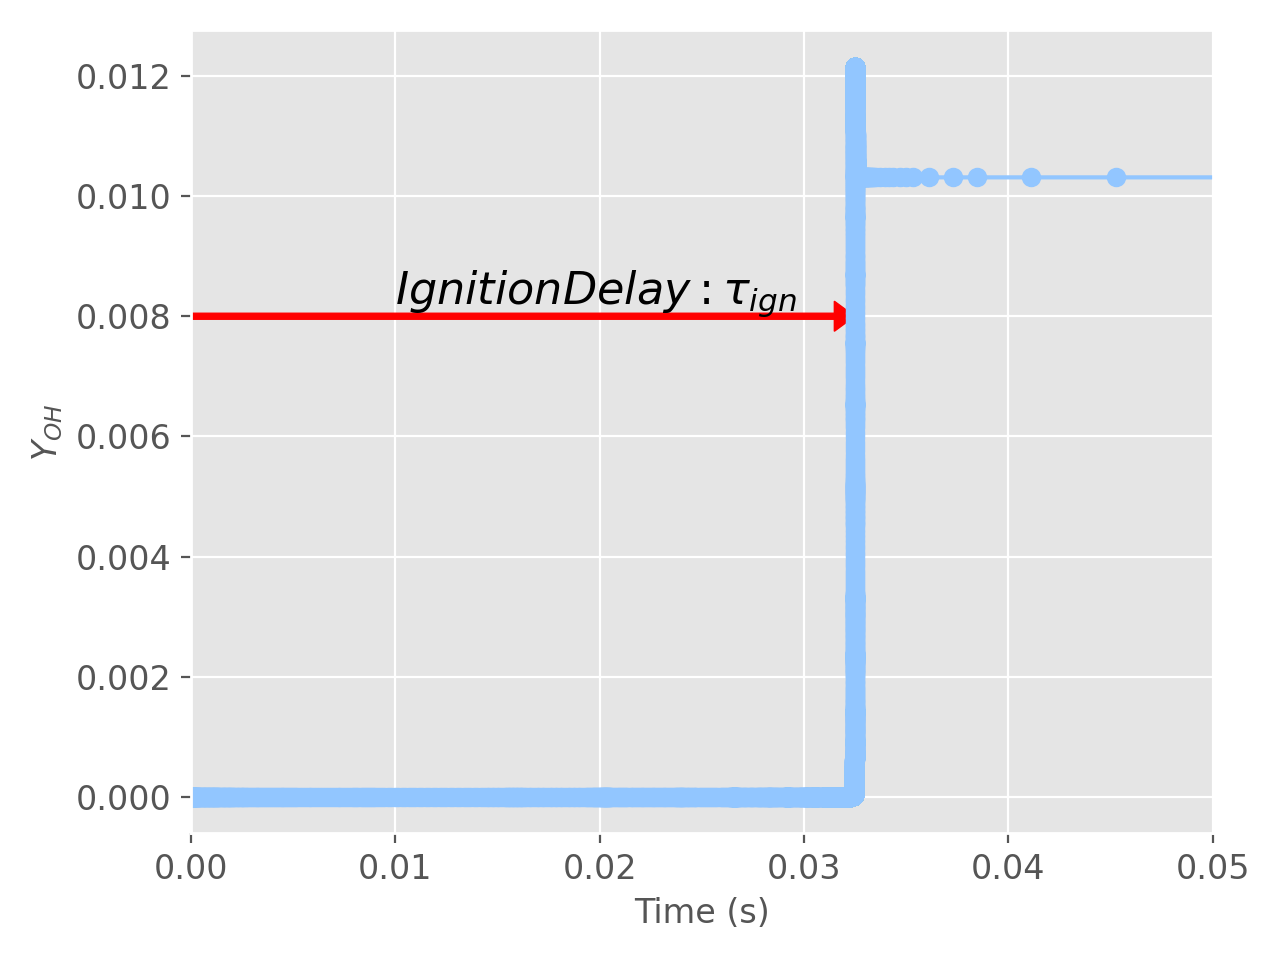

In [9]:
figure, axis = plt.subplots()
axis.plot(time_history.t, time_history(reference_species).Y, "-o")
axis.set_xlabel("Time (s)")
axis.set_ylabel("$Y_{OH}$")

axis.set_xlim([0,0.05])
axis.arrow(0, 0.008, tau, 0, width=0.0001, head_width=0.0005,
           head_length=0.001, length_includes_head=True, color="r", shape="full")
axis.annotate(r"$Ignition Delay: \tau_{ign}$", xy=(0,0), xytext=(0.01, 0.0082), fontsize=16);

## Illustration : NTC behavior

A common benchmark for a reaction mechanism is its ability to reproduce the **N**egative **T**emperature **C**oefficient behavior. Intuitively, as the temperature of an explosive mixture increases, it should ignite faster. But, under certain conditions, we observe the opposite. This is referred to as NTC behavior. Reproducing experimentally observed NTC behavior is thus an important test for any mechanism. We will do this now by computing and visualizing the ignition delay for a wide range of temperatures

### Define the temperatures for which we will run the simulations

In [10]:
# Make a list of all the temperatures we would like to run simulations at
T = np.hstack((np.arange(1800, 900, -100), np.arange(975, 475, -25)))

estimated_ignition_delay_times = np.ones_like(T, dtype=float)

# Make time adjustments for the highest and lowest temperatures. This we do empirically
estimated_ignition_delay_times[:6] = 6 * [0.1]
estimated_ignition_delay_times[-4:-2] = 10
estimated_ignition_delay_times[-2:] = 100

# Now create a SolutionArray out of these
ignition_delays = ct.SolutionArray(gas, shape=T.shape, extra={"tau": estimated_ignition_delay_times})
ignition_delays.set_equivalence_ratio(1.0,  fuel="nc7h16", oxidizer={"o2": 1.0, "n2": 3.76})
ignition_delays.TP = T, reactor_pressure

Now, what we will do is simply run the code above the plots for each temperature.

In [11]:
for i, state in enumerate(ignition_delays):
    # Setup the gas and reactor
    gas.TPX = state.TPX
    r = ct.IdealGasReactor(contents=gas, name="Batch Reactor")
    reactor_network = ct.ReactorNet([r])

    reference_species_history = []
    time_history = []

    t0 = time.time()

    t = 0
    while t < estimated_ignition_delay_times[i]:
        t = reactor_network.step()
        time_history.append(t)
        reference_species_history.append(gas[reference_species].X[0])

    i_ign = np.array(reference_species_history).argmax()
    tau = time_history[i_ign]
    t1 = time.time()

    print(f"Computed Ignition Delay: {tau:.3e} s for T={state.T:.3f} K. "
          f"Took {t1-t0:.2f} s to compute")

    ignition_delays.tau[i] = tau

Computed Ignition Delay: 2.984e-05 s for T=1800.000 K. Took 0.35 s to compute
Computed Ignition Delay: 3.105e-05 s for T=1700.000 K. Took 0.33 s to compute
Computed Ignition Delay: 4.092e-05 s for T=1600.000 K. Took 0.28 s to compute
Computed Ignition Delay: 7.174e-05 s for T=1500.000 K. Took 0.31 s to compute
Computed Ignition Delay: 1.645e-04 s for T=1400.000 K. Took 0.34 s to compute
Computed Ignition Delay: 4.748e-04 s for T=1300.000 K. Took 0.34 s to compute
Computed Ignition Delay: 1.632e-03 s for T=1200.000 K. Took 0.34 s to compute
Computed Ignition Delay: 6.443e-03 s for T=1100.000 K. Took 0.35 s to compute
Computed Ignition Delay: 3.248e-02 s for T=1000.000 K. Took 0.41 s to compute
Computed Ignition Delay: 5.040e-02 s for T=975.000 K. Took 0.40 s to compute
Computed Ignition Delay: 7.909e-02 s for T=950.000 K. Took 0.44 s to compute
Computed Ignition Delay: 1.252e-01 s for T=925.000 K. Took 0.42 s to compute
Computed Ignition Delay: 1.983e-01 s for T=900.000 K. Took 0.45 s t

### Figure: ignition delay ($\tau$) vs. the inverse of temperature ($\frac{1000}{T}$). 

<IPython.core.display.Javascript object>


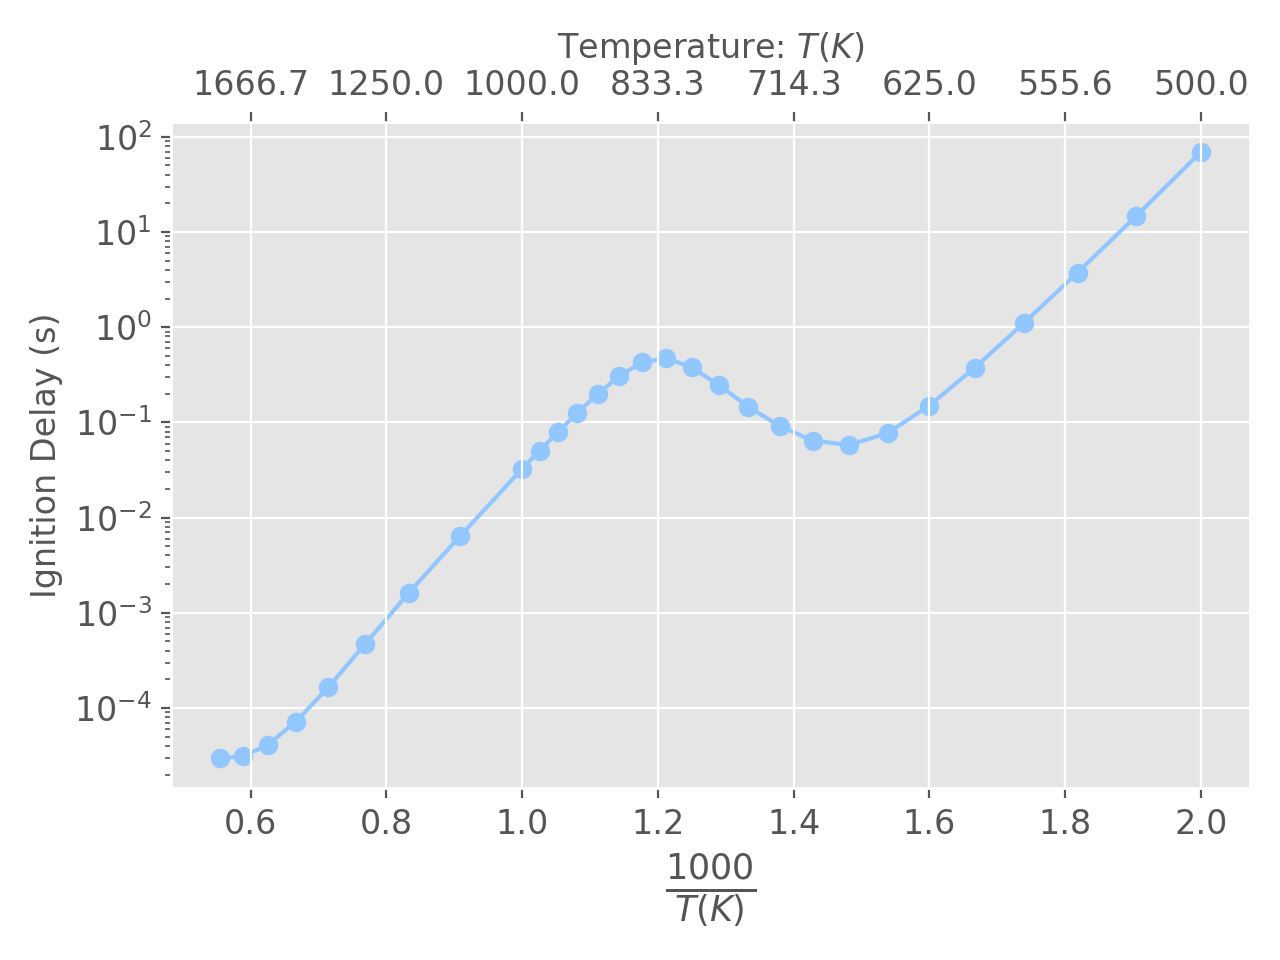

In [15]:
figure, axis = plt.subplots()
axis.semilogy(1000.0 / ignition_delays.T, ignition_delays.tau, "o-")
axis.set_ylabel("Ignition Delay (s)")
axis.set_xlabel(r"$\frac{1000}{T (K)}$", fontsize=18)

# Add a second axis on top to plot the temperature for better readability
T_axis = axis.twiny()
ticks = axis.get_xticks()
T_axis.set_xticks(ticks)
T_axis.set_xticklabels((1000/ticks).round(1))
T_axis.set_xlim(axis.get_xlim())
T_axis.set_xlabel("Temperature: $T(K)$");